# Project 4, APS1070 Winter 2021
#### **Linear Regression -  15 points**
**Deadline: April 10, 23:00**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Your **name**: Jinwei Yin
*   Your **student number**: 1002896672



## Part 1 - Getting Started [1 mark]

In Parts 1- 6 of this project, we are designing a controller to manage the ailerons of an F16 Aircraft! 

![Ailerons](https://raw.githubusercontent.com/aps1070-2019/datasets/master/img/airplane.gif) [Ref](https://www.grc.nasa.gov/www/k-12/BGA/Mike/airplane_parts_act.htm) 


The features describe the airplane's status, and our goal is to predict the `Goal` column, which is a command that our controller should issue. We will make our predictions by implementing linear regression without regularization.

In [1]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

1. Print the dataframe.
2. Prepare your dataset as follows: **[0.5]**
*   Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=0`.
*   Standardize the data using StandardScaler from sklearn.
*   Insert a first column of 1s in both the training and validation data sets.
3. Explain why we should not insert the column of 1s before standardization. **[0.5]**

In [2]:
### YOUR CODE HERE ###
# Q1
df

,inputs ClimbRate,Sgz,P,Q,CurPitch,CurRoll,AbsRoll,DiffClb,DiffRollRate,DiffDiffClb,SeTime1,SeTime2,SeTime3,SeTime4,SeTime5,SeTime6,SeTime7,SeTime8,SeTime9,SeTime10,SeTime11,SeTime12,SeTime13,SeTime14,DiffSeTime1,DiffSeTime2,DiffSeTime3,DiffSeTime4,DiffSeTime5,DiffSeTime6,DiffSeTime7,DiffSeTime8,DiffSeTime9,DiffSeTime10,DiffSeTime11,DiffSeTime12,DiffSeTime13,DiffSeTime14,Alpha,Se,Goal
0,-17,-6,-0.03,0.14,0.59,-0.5,-11,-9,0.015,-0.2,0.019,0.019,0.019,0.020,0.020,0.020,0.020,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.000,0.0,-0.002,0.0,0.0,0.0,-0.002,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.6,0.021,-0.0008
1,-791,15,-0.28,-0.34,1.11,0.9,-10,27,-0.002,4.7,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.4,0.013,-0.0009
2,-46,48,-0.42,0.07,0.57,0.6,-5,-8,-0.008,0.0,0.018,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,-0.002,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.019,-0.0005
3,496,-5,-0.21,-0.04,0.03,-0.5,-7,6,-0.002,-0.1,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.018,0.018,0.017,-0.001,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.001,0.0,0.001,0.0,0.5,0.017,-0.0005
4,-124,16,-0.02,0.05,0.61,-0.2,-9,-3,0.000,0.0,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.018,-0.0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13745,-53,-13,-0.07,0.02,0.58,-2.3,-15,12,0.022,-0.8,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,-0.001,0.0,0.5,0.019,-0.0007
13746,1,4,-0.11,-0.07,0.47,0.8,-5,8,-0.003,-0.2,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.016,-0.0004
13747,425,-14,0.40,0.07,0.41,-2.1,-16,12,0.031,-0.7,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.034,0.034,0.034,0.034,0.032,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.001,0.0,0.000,0.0,0.001,0.0,0.9,0.032,-0.0015
13748,102,-10,-0.19,0.08,1.30,0.5,-10,-3,-0.003,-0.2,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,1.4,0.051,-0.0015


In [3]:
# Q2
# Split the dataset
from sklearn.model_selection import train_test_split
y = df["Goal"].values
X = df.drop(columns="Goal").values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Insert a first column of 1s in both the training and validation data sets
import numpy as np
X_train_scaled = np.hstack((np.ones((11000,1)), X_train_scaled))
X_test_scaled = np.hstack((np.ones((2750,1)), X_test_scaled))

Q3

If we insert the column of 1s before standardization, then we will get a column of 0s after standardization, which is not we want.

## Part 2 - Linear Regression - Direct Solution [1 marks]

Implement the direct solution to linear regression on the training set. **[0.5]**

Report the root-mean-square error (RMSE) for both the training and validation sets.**[0.5]**

In [4]:
### YOUR CODE HERE ###
from sklearn.metrics import mean_squared_error
import scipy
def rmse(yPred, y):
  return np.sqrt(mean_squared_error(yPred, y))
  
W = np.dot(scipy.linalg.inv(np.dot(X_train_scaled.T, X_train_scaled)), np.dot(X_train_scaled.T, y_train))
y_pred_train = np.dot(X_train_scaled, W)

y_pred_valid = np.dot(X_test_scaled, W)

RMSE_train = rmse(y_pred_train, y_train)
RMSE_valid = rmse(y_pred_valid, y_test)
print ("RMSE on training set: " , RMSE_train)
print ("RMSE on validation set: " , RMSE_valid)

RMSE on training set:  0.00017471904642643232
RMSE on validation set:  0.00016954898384832063


## Part 3 - Full Batch Gradient Descent [2 marks]

We will now implement a full batch gradient descent algorithm and record the training time for our model.

1. Implement gradient descent for linear regression using a fixed learning rate of $\alpha= 1e-2$, and by iterating until your model's **validation** RMSE converges. Here we will consider it converged once **validation RMSE is within 0.1% of the Direct Solution RMSE on the validation set** (i.e., $RMSE_{GD} <= RMSE_{Direct Solution}*1.001$). We call this value **Convergence threshold ($CT = RMSE_{Direct Solution}*1.001$)** and will use this value in the next parts too.

  *  Record the training time (from the first iteration until convergence) using the `time.time()` function. Be sure to compute the gradients yourself! Take a look at the code provided in the tutorial.**[0.5]**

  * Plot the Training RMSE and the Validation RMSE vs epoch on the same figure. Epoch is the number of passes on the full training set - for full batch gradient descent, it's the same as the # of gradient updates (iterations). **[0.5]**

2. Comment on overfitting/underfitting? **[1]**

**Hint**: 

Initialize your weights with small random numbers (<$0.001$)

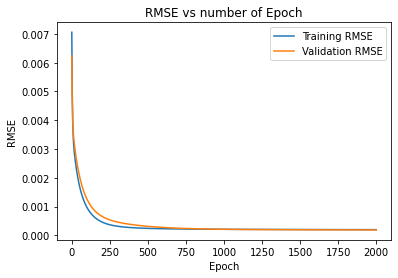

--- Total Training Time: 3.617908239364624 (s) ---


In [5]:
# Q1
import matplotlib.pyplot as plt
import time
start_time = time.time() ## Records current time
lr = 1e-2 # learning rate
CT = 1.001*RMSE_valid
w = (np.random.random(41)/1000).reshape(1,-1) ### Inital weights
## GD Script -- Sample code in tutorial! ##
y_train = y_train.reshape(-1,1)
rmse_training,rmse_val = [],[]
for epoch in range (0, 2000):
  y_predict_train = np.dot(X_train_scaled, w.T).reshape(-1,1)
  rmse_training.append(rmse(y_predict_train, y_train))
  gradient = (1/len(y_predict_train) * np.dot(X_train_scaled.T, y_predict_train-y_train)).reshape(1,-1) 
  w = w - lr * gradient # weight update
  y_predict_valid = np.dot(X_test_scaled, w.T)
  rmse_val.append(rmse(y_predict_valid, y_test))
  if rmse(y_predict_valid, y_test) <= CT:
    break

plt.plot(rmse_training, label = 'Training RMSE')
plt.plot(rmse_val, label = 'Validation RMSE')
plt.title("RMSE vs number of Epoch")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()
print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))

Q2

For the first few iterations, there is an underfitting because RMSE for both  of the training set and the validation set are high. However, as the number of epoch increases, RMSE for both of the training set and the validation set decreases. And overfitting appears after the model passes convergence threshold.

## Part 4 - Mini-batch and Stochastic Gradient Descent [3.5 marks]

Write a function that performs mini-batch gradient descent until the convergence threshold (CT) is reached. **[1]**

The inputs of that function are 
  * Input data (tarining/validation)
  * Batch size
  * Learning Rate
  * Convergence Threshold (CT)

Your function will return the following arrays: 
 * The final weights after training.
 * The training RMSE at each epoch (the number of epochs is the number of passes on the full data set).
 * The validation RMSE at each epoch.
 * An array that has the elapsed time from the start of the training process to the end of each epoch (e.g., if each epoch takes exactly 2 seconds, the array would look like: [2 4 6 8 ...]).

Notes: 
* For certain batch sizes, GD might not converge to a solution. For that reason, you need to check the RMSE of the validation/training set at each epoch, and if it's getting larger and larger, you should stop the training for that case (the design is up to you!).
* CT will help you to know when your model is converged. 
* Remember to shuffle the training data after each epoch (select new mini-batches). 

Let's now use the function to investigate the effect of batch size on convergence. When the batch size is 1, we call that stochastic gradient descent. When the batch size equals the # of training data, it is full-batch (i.e., all data points are used at every iteration). Anywhere in between is mini-batch (we use some of the data).
  * Sweep different values for the mini-batch size (at least 10 values, including 1 -- Stochastic GD), each time using a learning rate of $\alpha= 1e-2$. **Hint: Try batch sizes that are powers of two (e.g., 2,4,8,16,32,...).** These batch sizes fit better on the hardware and may achieve higher performance.  **[0.5]**
  * Plot training and validation RMSE vs. **epoch** for all the **converging** batch sizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE. **[0.5]**
  * Plot training and validation RMSE vs. **time** for all the **converging** batch sizes in a figure. The X-axis is Time, and the Y-axis is RMSE. **[0.5]**
  * Plot Total training time (y-axis) vs. Batch size (x-axis). **[0.5]**
  * Describe your findings, including the main takeaways from each of your plots. **[0.5]**

In [14]:
### YOUR CODE HERE ###
import math
def minibatch_and_stochastic_gradient_descent(x_train,y_train,x_valid,y_valid,bs,lr,CT):
  maximum_iterations = 15000
  count = 0 # count the number of iterations
  w = (np.random.random(41)/10000).reshape(1,-1) # Inital weights
  weight = [] # weight array
  rmse_val = 5
  m = x_train.shape[0]
  rmse_train,rmse_valid = [],[] # RMSE array for training and validation set
  start_time = time.time()
  elapsed_time = []
  total_time = []
  converge = True
  np.random.seed(42)
  while count <= maximum_iterations and rmse_val > CT:
    for i in range(0,m,bs):
      x_train_batched = x_train[i:i+bs,:]     
      y_train_batched = y_train[i:i+bs]
      y = np.dot(x_train_batched,w.T).reshape(-1,1)
      gradient = (1/len(y_train_batched) * np.dot(x_train_batched.T, y-y_train_batched)).reshape(1,-1) 
      w = w - lr * gradient
      count += 1
    for i in w[0]:
      if math.isnan(i) or i>10000:
        converge = False
        return [],[],[],[],[],converge
    elapsed_time.append(time.time() - start_time) 
    y_predict_train = np.dot(x_train, w.T).reshape(-1,1)
    y_predict_valid = np.dot(x_valid, w.T).reshape(-1,1)
    rmse_training = rmse(y_predict_train,y_train)
    rmse_val = rmse(y_predict_valid,y_valid)
    weight.append(w)
    rmse_train.append(rmse_training)
    rmse_valid.append(rmse_val)
  if count > maximum_iterations:
    converge = False
  total_time.append(elapsed_time[-1])      
  return weight[-1], rmse_train, rmse_valid, elapsed_time, total_time, converge

In [7]:
# When batch size is 1,2,4, the model diverges.
final_weight, rmse_train, rmse_valid, elapsed_time, total_time, converge1 = minibatch_and_stochastic_gradient_descent(X_train_scaled,y_train,X_test_scaled,y_test,1,1e-2,CT)
final_weight, rmse_train, rmse_valid, elapsed_time, total_time, converge2 = minibatch_and_stochastic_gradient_descent(X_train_scaled,y_train,X_test_scaled,y_test,2,1e-2,CT)
final_weight, rmse_train, rmse_valid, elapsed_time, total_time, converge4 = minibatch_and_stochastic_gradient_descent(X_train_scaled,y_train,X_test_scaled,y_test,4,1e-2,CT)
print(converge1)
print(converge2)
print(converge4)

False
False
False


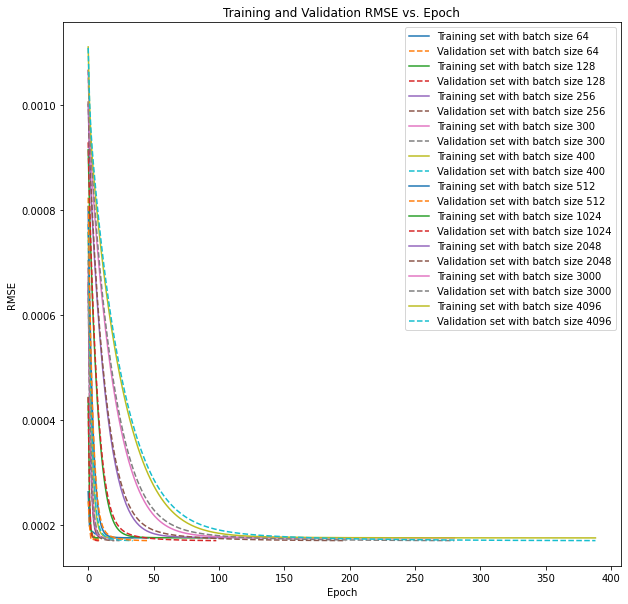

In [8]:
# training and validation RMSE vs. epoch
batch_size = [64,128,256,300,400,512,1024,2048,3000,4096]  # mini-batch size selection: 64,128,256,300,400,512,1024,2048,3000,4096
plt.figure(figsize=(10,10))
for i in batch_size:
  final_weight, rmse_train, rmse_valid, elapsed_time, total_time, converge = minibatch_and_stochastic_gradient_descent(X_train_scaled,y_train,X_test_scaled,y_test,i,1e-2,CT)
  plt.plot(range(len(rmse_train)), rmse_train, label = 'Training set with batch size {}'.format(i)) 
  plt.plot(range(len(rmse_valid)), rmse_valid, label = 'Validation set with batch size {}'.format(i),linestyle = 'dashed') 
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.title('Training and Validation RMSE vs. Epoch')
  plt.legend()

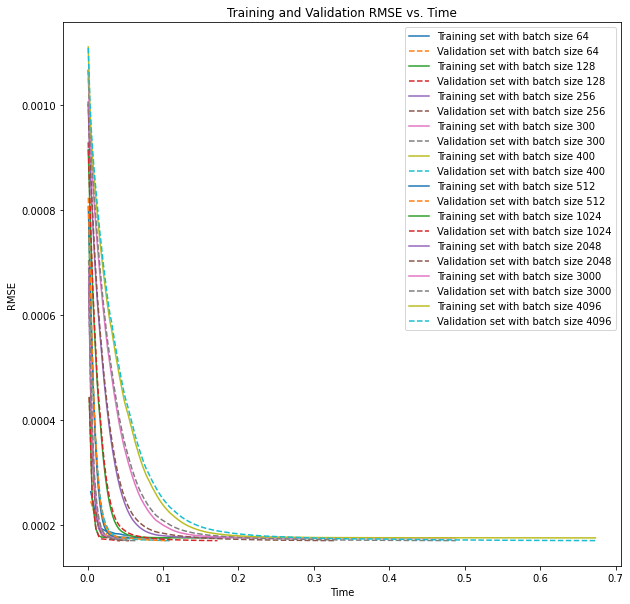

In [9]:
# training and validation RMSE vs. time
batch_size = [64,128,256,300,400,512,1024,2048,3000,4096]  # mini-batch size selection: 64,128,256,300,400,512,1024,2048,3000,4096
plt.figure(figsize=(10,10))
for i in batch_size:
  final_weight, rmse_train, rmse_valid, elapsed_time, total_time, converge = minibatch_and_stochastic_gradient_descent(X_train_scaled,y_train,X_test_scaled,y_test,i,1e-2,CT)
  plt.plot(elapsed_time, rmse_train, label = 'Training set with batch size {}'.format(i)) 
  plt.plot(elapsed_time, rmse_valid, label = 'Validation set with batch size {}'.format(i),linestyle = 'dashed') 
  plt.xlabel('Time')
  plt.ylabel('RMSE')
  plt.title('Training and Validation RMSE vs. Time')
  plt.legend()

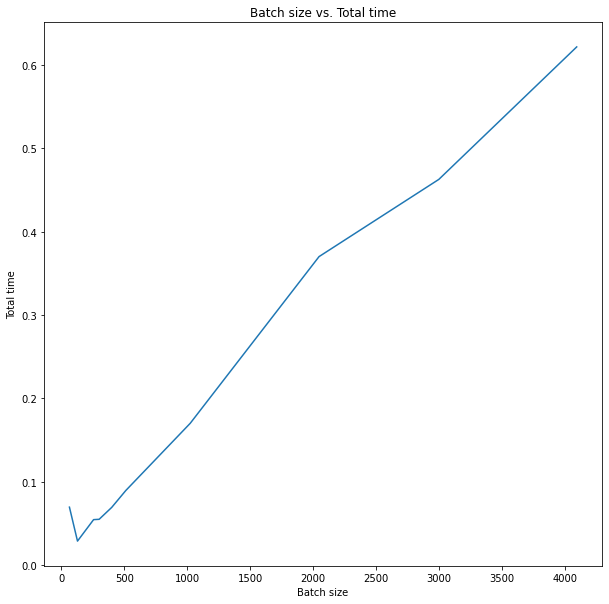

In [10]:
# Total time vs. batch size
batch_size = [64,128,256,300,400,512,1024,2048,3000,4096]  # mini-batch size selection: 64,128,256,300,400,512,1024,2048,3000,4096
plt.figure(figsize=(10,10))
t = []
for i in batch_size:
  final_weight, rmse_train, rmse_valid, elapsed_time, total_time, converge = minibatch_and_stochastic_gradient_descent(X_train_scaled,y_train,X_test_scaled,y_test,i,1e-2,CT)
  t.append(total_time)
plt.plot(batch_size, t) 
plt.xlabel('Batch size')
plt.ylabel('Total time')
plt.title('Batch size vs. Total time')
plt.show()

Training and Validation RMSE vs. Epoch:

For this plot, I select 10 different values of batch size, and use each of the batch size to calculate the gradient and then update the weight in each iteration. From this plot, we can see that the model with smaller batch size converges faster than with larger batch size.  

Training and Validation RMSE vs. Time:

For this plot, I used the same method as the previous plot. From this plot, we can see that the model with smaller batch size converges faster than with larger batch size.

Batch size vs. Total time:

From this plot, we can see that total time increses as batch size increses. However, there is a decrease at the beginning, which indicates that 128 is the best batch size among the batch sizes I chose.

## Part 5 - Gradient Descent Learning Rate [2 marks]
Use the function that you designed in Part 4 to investigate the effect of learning rate on convergence.

1. What is the largest learning rate that you can find so that the non-converging batch sizes in the last part converge to a solution. Report your findings in a table. Mention batch size, learning rate, and training and validation RMSE. **[0.5]**

2. Select the best batchsize based on Part 4's fastest convergence time and sweep the learning rate (at least 10 values, all should converge) while applying Mini-batch GD. 
  
  * Plot the training and validation RMSE vs. **epoch** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  * Plot the training and validation RMSE vs. **time** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  * Describe your findings, including the main takeaways from each of your plots. **[0.5]**

In [12]:
### YOUR CODE HERE ###
# non-converging batch sizes: 1,2,4

learning_rate = []
for i in [1,2,4]:
  max_lr = 0.001
  lr = 0.001
  while lr < 1:
    final_weight, rmse_train, rmse_valid, elapsed_time, total_time,converge = minibatch_and_stochastic_gradient_descent(X_train_scaled,y_train,X_test_scaled,y_test,i,lr,CT)
    if converge:
      max_lr = lr
    lr += 0.001
  learning_rate.append(max_lr)
b = ([1,2,4])
data = np.array([b,learning_rate,rmse_train,rmse_valid])
pd.DataFrame(data=data, index=['batch size', 'learning rate','rmse_training','rmse_validation'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in subtract
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in subtract
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


,0
batch size,"[1, 2, 4]"
learning rate,"[0.002, 0.003, 0.003]"
rmse_training,[]
rmse_validation,[]


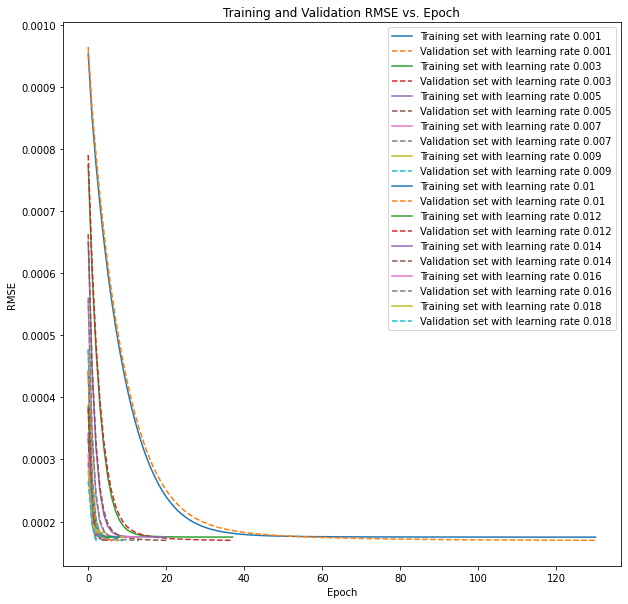

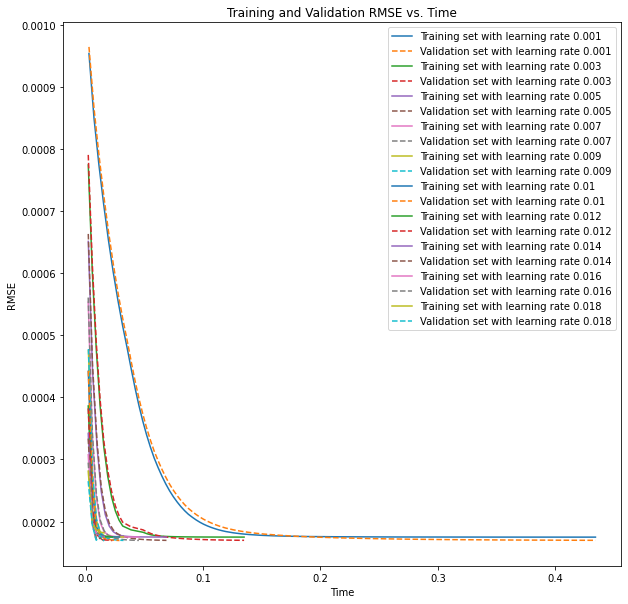

In [13]:
# Q2
# My best batch size is 128.
r = [0.001,0.003,0.005,0.007,0.009,0.01,0.012,0.014,0.016,0.018] # learning rate
plt.figure(figsize=(10,10))
for i in r:  
  final_weight, rmse_train, rmse_valid, elapsed_time, total_time, converge = minibatch_and_stochastic_gradient_descent(X_train_scaled,y_train,X_test_scaled,y_test,128,i,CT)
  plt.plot(range(len(rmse_train)), rmse_train, label = 'Training set with learning rate {}'.format(i)) 
  plt.plot(range(len(rmse_valid)), rmse_valid, label = 'Validation set with learning rate {}'.format(i),linestyle = 'dashed') 
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.title('Training and Validation RMSE vs. Epoch')
  plt.legend()

plt.figure(figsize=(10,10))
for i in r:
  final_weight, rmse_train, rmse_valid, elapsed_time, total_time, converge = minibatch_and_stochastic_gradient_descent(X_train_scaled,y_train,X_test_scaled,y_test,128,i,CT)
  plt.plot(elapsed_time, rmse_train, label = 'Training set with learning rate {}'.format(i)) 
  plt.plot(elapsed_time, rmse_valid, label = 'Validation set with learning rate {}'.format(i),linestyle = 'dashed') 
  plt.xlabel('Time')
  plt.ylabel('RMSE')
  plt.title('Training and Validation RMSE vs. Time')
  plt.legend()

Training and Validation RMSE vs. Epoch:

From this plot we can see that smaller learning rate has larger number of epoch, while larger learning rate has smaller number of epoch. This is reasonable because small learning rate update weight slowly, which requires more iterations to converge.

Training and Validation RMSE vs. Time:

From this plot we can see that smaller learning rate takes more time than larger learning rate to converge. The reason is because small learning rate update weight slowly, which requires more iterations to converge.

## Part 6 - Introducing Momentum [1.5 marks]
Momentum is a popular technique that helps the gradient descent algorithm to converge faster. Simply, it behaves like a moving average of gradients. First, take a look at [here](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) to get familiar with the concept.

To summarize, If the weight update formula in the time-step $t$ is $w_t = w_{t-1} - \alpha~g_t$, where $\alpha$ is the learning rate and $g_t$ is your gradient (weight updates), the $g_t$ using momentum could be computed as $g_t = \beta~g_{t-1} + (1-\beta) \frac{{\partial J}}{\partial w}$.

 $\beta$ is the momentum coefficient, between [0, 1]. Weight updates ($g_t$) with momentum are not only computed based on the derivative of the loss function but also are a function of previous weight updates.

If you put $\beta=0$ in the $g_t$ equation, it would be the original gradient descent method. 

Pick one of your best models from the previous part and try to investigate the effect of momentum.
  * Plot the training and validation RMSE vs. **epoch** (x-axis) for all the momentums that you tried in a figure. **[0.5]**
  * Plot the training and validation RMSE vs. **time** (x-axis) for all the momentums that you tried in a figure. **[0.5]**
  * Describe your findings, including the main takeaways from each of your plots. **[0.5]**

In [19]:
### YOUR CODE HERE ###
def momentum(x_train,y_train,x_valid,y_valid,bs,lr,CT,beta):
  maximum_iterations = 15000
  count = 0 # count the number of iterations
  w = (np.random.random(41)/10000).reshape(1,-1) # Inital weights
  g = np.zeros((x_train.shape[1], 1)).reshape(1,-1)
  weight = [] # weight array
  rmse_val = 5
  m = x_train.shape[0]
  rmse_train,rmse_valid = [],[] # RMSE array for training and validation set
  start_time = time.time()
  elapsed_time = []
  total_time = []
  converge = True
  np.random.seed(42)
  while count <= maximum_iterations and rmse_val > CT:
    for i in range(0,m,bs):
      x_train_batched = x_train[i:i+bs,:]     
      y_train_batched = y_train[i:i+bs]
      y = np.dot(x_train_batched,w.T).reshape(-1,1)
      gradient = (1/len(y_train_batched) * np.dot(x_train_batched.T, y-y_train_batched)).reshape(1,-1)
      g = beta*g + (1-beta)*gradient
      w = w - lr * g
      count += 1
    for i in w[0]:
      if math.isnan(i) or i>10000:
        converge = False
        return [],[],[],[],[],converge
    elapsed_time.append(time.time() - start_time) 
    y_predict_train = np.dot(x_train, w.T).reshape(-1,1)
    y_predict_valid = np.dot(x_valid, w.T).reshape(-1,1)
    rmse_training = rmse(y_predict_train,y_train)
    rmse_val = rmse(y_predict_valid,y_valid)
    weight.append(w)
    rmse_train.append(rmse_training)
    rmse_valid.append(rmse_val)
  if count > maximum_iterations:
    converge = False
  total_time.append(elapsed_time[-1])      
  return weight[-1], rmse_train, rmse_valid, elapsed_time, total_time, converge

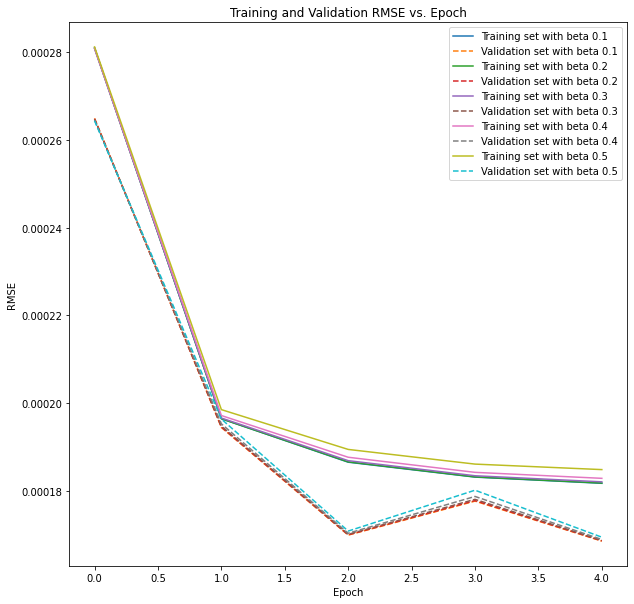

In [21]:
# using learning rate = 0.018, batch size = 128
beta = [0.1,0.2,0.3,0.4,0.5]
plt.figure(figsize=(10,10))
for b in beta:
  final_weight, rmse_train, rmse_valid, elapsed_time, total_time, converge = momentum(X_train_scaled,y_train,X_test_scaled,y_test,128,0.018,CT,b)
  plt.plot(range(len(rmse_train)), rmse_train, label = 'Training set with beta {}'.format(b)) 
  plt.plot(range(len(rmse_valid)), rmse_valid, label = 'Validation set with beta {}'.format(b),linestyle = 'dashed') 
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.title('Training and Validation RMSE vs. Epoch')
  plt.legend()

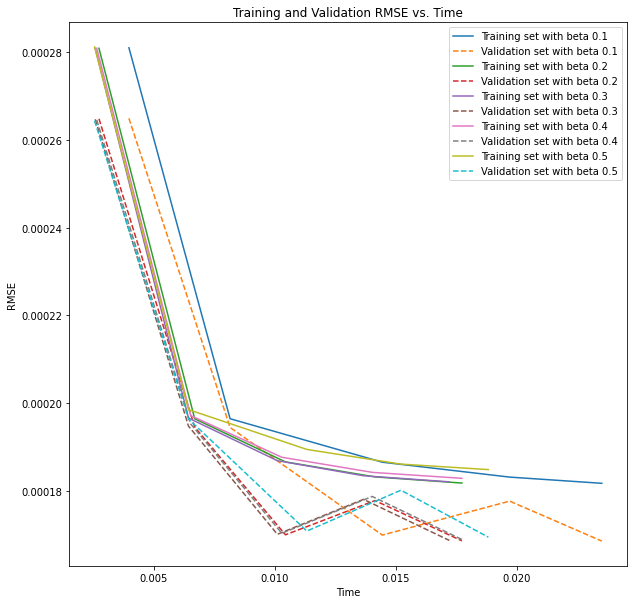

In [22]:
beta = [0.1,0.2,0.3,0.4,0.5]
plt.figure(figsize=(10,10))
for b in beta:
  final_weight, rmse_train, rmse_valid, elapsed_time, total_time, converge = momentum(X_train_scaled,y_train,X_test_scaled,y_test,128,0.018,CT,b)
  plt.plot(elapsed_time, rmse_train, label = 'Training set with beta {}'.format(b)) 
  plt.plot(elapsed_time, rmse_valid, label = 'Validation set with beta {}'.format(b),linestyle = 'dashed') 
  plt.xlabel('Time')
  plt.ylabel('RMSE')
  plt.title('Training and Validation RMSE vs. Time')
  plt.legend()

From the two plots above, we can see that the training set RMSE is higher than the validation set RMSE. Among the beta value I used, 0.3 is my best beta value for convergence. And the model convergers faster with larger value of beta than smaller value of beta. However, we can see that there exists instabilities in validation curves.

## Part 7 - Finalizing a model [1 marks]
Based on your findings from the previous parts (Parts 1 - 6), pick a model (or combination of model settings) that you think would work best for our dataset and evaluate it on the training and validation sets. Briefly justify your model selections/settings. Summarize the performance of your model for the task of managing ailerons of an F16 aircraft. In your summary please provide pros and cons of using this linear regression model to solve the problem.

In [33]:
### YOUR CODE HERE ###
# The model in part 6 with beta = 0.3 is my best model.
maximum_iterations = 15000
count = 0 # count the number of iterations
w = (np.random.random(41)/10000).reshape(1,-1) # Inital weights
g = np.zeros((X_train_scaled.shape[1], 1)).reshape(1,-1)
weight = [] # weight array
rmse_val = 5
m = X_train_scaled.shape[0]
rmse_train,rmse_valid = [],[] # RMSE array for training and validation set
start_time = time.time()
elapsed_time = []
total_time = []
np.random.seed(42)
while count <= maximum_iterations and rmse_val > CT:
  for i in range(0,m,128):
    x_train_batched = X_train_scaled[i:i+128,:]     
    y_train_batched = y_train[i:i+128]
    y = np.dot(x_train_batched,w.T).reshape(-1,1)
    gradient = (1/len(y_train_batched) * np.dot(x_train_batched.T, y-y_train_batched)).reshape(1,-1)
    g = 0.3*g + (1-0.3)*gradient
    w = w - 0.018 * g
    count += 1
  elapsed_time.append(time.time() - start_time) 
  y_predict_train = np.dot(X_train_scaled, w.T).reshape(-1,1)
  y_predict_valid = np.dot(X_test_scaled, w.T).reshape(-1,1)
  rmse_training = rmse(y_predict_train,y_train)
  rmse_val = rmse(y_predict_valid,y_test)
  weight.append(w)
  rmse_train.append(rmse_training)
  rmse_valid.append(rmse_val)
if count > maximum_iterations:
  converge = False
total_time.append(elapsed_time[-1])

In [34]:
print("Number of iterations to converge:", count)
print("Total time to converge:", total_time[0])

Number of iterations to converge: 430
Total time to converge: 0.025423765182495117


Momentum technique helps the gradient descent algorithm converge faster. However, using this technique is computationally costly because it requires tuning of hyper-parameters using K-fold cross validation on training set.

## Part 8 - Getting started with Github  [3 marks]

This final part of the project assignment is to be completed independently from Parts 1 - 7. In this part you will be completing some additional coding tasks using a different dataset and submitting your results onto Github. To access this part of the assignment and upload your answers, you will need to use Github. Please complete the following step-by-step instructions:

 0. Create a Github account and install git for Windows or Mac: 
  * https://git-scm.com/download/win
  * https://git-scm.com/download/mac

 1. Open this link: https://classroom.github.com/a/cMZn2WxY to create your assignment repository in GitHub. You should get a link similar to:
```
https://github.com/aps1070-2019/project-4-git-******
```
This your private repository to get this part questions and upload your answers. **Copy this link to the text box below to be graded for this part.**

 
 2. Open `Git Bash`, the app you downloaded in step `0`, and set your Email and username by:
```
git config --global user.email “<your-GitHub-email>”
git config --global user.name “<your-GitHub-username>”
```

 3. Create a folder for the course on your computer and `cd` to that. `cd` means `Change Directory`. For example, on a Windows machine, where I have a folder on "C:\aps1070":
 ```
cd c:aps1070
```
 4. Get your assignment by the link you got in step 1:
```
git clone https://github.com/aps1070-2019/project-4-git-******
```


 5. A new folder should be created in your directory similar to:
```
C:\aps1070\project-4-git-********
```
This folder has an `ipynb` notebook which you need to manually upload to colab and answer its questions. 

 6. After you finished working on this notebook, download the notebook from colab and move it to the directory in step 5.

 7. Replace the old notebook with the new one that has your answers. Make sure your completed notebook has the same name as the original notebook you downloaded. 

 8. To submit your work, follow: 
```
cd <your assignment folder>
git add Project_4_git.ipynb
git commit -m “Final Submission”
git push origin master
```

 9. Make sure your submission is ready for grading. Open the private repository link that you copied below in your browser and make sure you can see your final submission with your latest changes there. 

**Private Repository Link :** ------------------- `<https://github.com/aps1070-2019/project-4-git-j34yin>` ---------------- **[3 marks]**